## Importing and normalizing data

In this notebook, we will train an autoencoder network starting from some ATLAS data, which we will first normalize.  

In [1]:
import pandas as pd
import re

def read_data(input_path):
    '''Reads data from the input_path CSV file.
    The format of the given CSV file is:
    event ID; process ID; event weight; MET; METphi; (continued to next line)
    obj1, E1, pt1, eta1, phi1; obj2, E2, pt2, eta2, phi2;...
    '''
    jets = []
    with open(input_path) as f:
        for line in f:
            tokens = re.split(',|;', line)
            for i, token in enumerate(tokens):
                if token == 'j':
                    current_jet = [float(e) for e in tokens[(i+1):(i+5)]]
                    jets.append(current_jet)
    return jets

# This is the input CSV file
input_path = r'monojet_Zp2000.0_DM_50.0_chan3.csv'
jets = read_data(input_path)

print('---------- Original dataset ----------')
full_df = pd.DataFrame(jets, columns=('energy','pt','eta','phi'))
print(full_df.head(5))


---------- Original dataset ----------
     energy        pt       eta      phi
0  258722.0  243675.0  0.328962  2.25014
1  520092.0  108590.0 -2.247300 -1.85679
2  383024.0   88405.6  2.145160 -1.95635
3   39507.6   35365.1  0.470460 -1.16445
4  225430.0   26878.2 -2.816080 -2.25938


In [2]:
import numpy as np

def forward_transform(df):
    '''Given a pandas dataframe df, containing 4-momentum
    of simulated particles, apply some transformations to render
    the distributions closer to normal. Depending on the activation
    function of the output layer of the autoencoder, we may need to
    normalize the data to [-1, +1].

    NOTE: If you modify this code, do not forget to also modify
    the inverse_transform() function accordingly.
    '''
    df['energy'] = np.log10(df['energy'])
    df['pt'] = np.log10(df['pt'])
    df['eta'] = df['eta'] / 5.
    df['phi'] = df['phi'] / 3.
    return df

def inverse_transform(df):
    '''Given a pandas dataframe df, containing transformed 4-momentum
    of simulated particles, apply the inverse transformations to reconstruct
    the original distributions withe their physical units.
    '''
    df['energy'] = 10. ** df['energy']
    df['pt'] = 10. ** df['pt']
    df['eta'] = 5. * df['eta']
    df['phi'] = 3. * df['phi']
    return df

print('-------- Forward transformed dataset --------')
full_df = forward_transform(full_df)
print(full_df.head(5))

print('-------- Inverse transformed dataset --------')
full_df = inverse_transform(full_df)
print(full_df.head(5))

# Apply again the forward transformation
full_df = forward_transform(full_df)

-------- Forward transformed dataset --------
     energy        pt       eta       phi
0  5.412833  5.386811  0.065792  0.750047
1  5.716080  5.035790 -0.449460 -0.618930
2  5.583226  4.946480  0.429032 -0.652117
3  4.596681  4.548575  0.094092 -0.388150
4  5.353012  4.429400 -0.563216 -0.753127
-------- Inverse transformed dataset --------
     energy        pt       eta      phi
0  258722.0  243675.0  0.328962  2.25014
1  520092.0  108590.0 -2.247300 -1.85679
2  383024.0   88405.6  2.145160 -1.95635
3   39507.6   35365.1  0.470460 -1.16445
4  225430.0   26878.2 -2.816080 -2.25938


Now we plot the data using the matplotlib library. The units reflect the normalization, but it's the shape that we care about. 

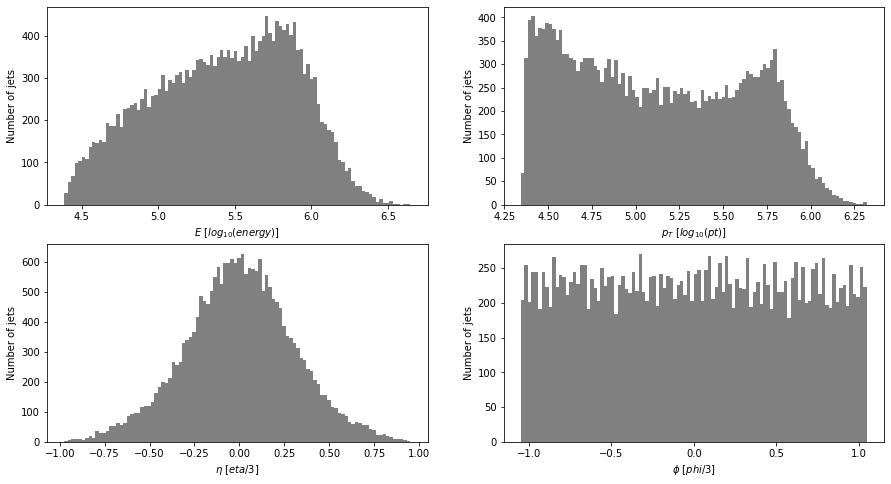

In [3]:
import matplotlib.pyplot as plt

unit_list = ['[$log_{10}(energy)$]', '$[log_{10}(pt)$]', '[$eta/3$]', '[$phi/3$]']
variable_list = [r'$E$', r'$p_T$', r'$\eta$', r'$\phi$']
branches=['energy', 'pt', 'eta', 'phi']
n_bins = 100

plt.figure(figsize=(15, 8))
for i in range(0, 4):
    plt.subplot(2, 2, i+1)
    n_hist_data, bin_edges, _ = plt.hist(
        full_df[branches[i]], color='gray', label='Input', alpha=1, bins=n_bins)
    plt.xlabel(xlabel=variable_list[i] + ' ' + unit_list[i])
    plt.ylabel('Number of jets')
plt.show()

## Setting up the network

### Preparing the data

Adding the two datasets as TensorDatasets to PyTorch (also loading all other classes we'll need later)

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from fastai import learner
from fastai.data import core

# Create a Tensor from the full_df pandas dataframe,
# after converting it to a numpy.ndarray.
full_te = torch.from_numpy(full_df.to_numpy()).to(dtype=torch.float32)
print('Tensor of 4-momentum of a jet:', full_te[0])

# Since we are building an autoencoder, by definition
# the input and the output is the same!
full_ds = TensorDataset(full_te, full_te)
print('Input tensor:', full_ds[0][0])
print('Output tensor:', full_ds[0][1])

# Split the full dataset into a train set (80%) and a test set (20%)
# Since we aren't doing any hyperparameter optimization, we don't have
# a separate validation set.
train_size = int(0.8 * len(full_ds))
test_size = len(full_ds) - train_size

train_ds, test_ds = torch.utils.data.random_split(full_ds, [train_size, test_size])

Tensor of 4-momentum of a jet: tensor([5.4128, 5.3868, 0.0658, 0.7500])
Input tensor: tensor([5.4128, 5.3868, 0.0658, 0.7500])
Output tensor: tensor([5.4128, 5.3868, 0.0658, 0.7500])


We now set things up to load the data, and we use a batch size that was optimized by previous students. Note also that this is fastai v2, migration thanks to Jessica Lastow.

In [5]:
bs = 256

# Converts the TensorDataset into a DataLoader object and
# combines into one DataLoaders object (a basic wrapper
# around several DataLoader objects). 
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=bs * 2)
dls = core.DataLoaders(train_dl, test_dl)

### Preparing the network

Here we have an example network. Details aren't too important, as long as they match what was already trained for us...in this case we have a LeakyReLU, tanh activation function, and a number of layers that goes from 4 to 200 to 20 to 3 (number of features in the hidden layer that we pick for testing compression) and then back all the way to 4. 

In [6]:
class AE_3D_200_LeakyReLU(nn.Module):
    def __init__(self, n_features=4):
        super(AE_3D_200_LeakyReLU, self).__init__()
        self.en1 = nn.Linear(n_features, 200)
        self.en2 = nn.Linear(200, 200)
        self.en3 = nn.Linear(200, 20)
        self.en4 = nn.Linear(20, 3)
        self.de1 = nn.Linear(3, 20)
        self.de2 = nn.Linear(20, 200)
        self.de3 = nn.Linear(200, 200)
        self.de4 = nn.Linear(200, n_features)
        self.tanh = nn.Tanh()

    def encode(self, x):
        return self.en4(self.tanh(self.en3(self.tanh(self.en2(self.tanh(self.en1(x)))))))

    def decode(self, x):
        return self.de4(self.tanh(self.de3(self.tanh(self.de2(self.tanh(self.de1(self.tanh(x))))))))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

    def describe(self):
        return 'in-200-200-20-3-20-200-200-out'

#model = AE_3D_200_LeakyReLU().double()
model = AE_3D_200_LeakyReLU()
model.to('cpu')

AE_3D_200_LeakyReLU(
  (en1): Linear(in_features=4, out_features=200, bias=True)
  (en2): Linear(in_features=200, out_features=200, bias=True)
  (en3): Linear(in_features=200, out_features=20, bias=True)
  (en4): Linear(in_features=20, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=20, bias=True)
  (de2): Linear(in_features=20, out_features=200, bias=True)
  (de3): Linear(in_features=200, out_features=200, bias=True)
  (de4): Linear(in_features=200, out_features=4, bias=True)
  (tanh): Tanh()
)

We now have to pick a loss function - MSE loss is appropriate for a compression autoencoder since it reflects the [(input-output)/input] physical quantity that we want to minimize. 

In [7]:
from fastai.metrics import mse
loss_func = nn.MSELoss()
wd = 1e-6
recorder = learner.Recorder()
learn = learner.Learner(dls, model=model, wd=wd, loss_func=loss_func, cbs=recorder)

## Training a new network

Instead of using a pre-trained network, an alternative is to train a new network and use that instead. 

First, we want to find the best learning rate. The learning rate is a hyper-paramater that sets how much the weights of the network will change each step with respect to the loss gradient.

Then we plot the loss versus the learning rates. We're interested in finding a good order of magnitude of learning rate, so we plot with a log scale.

A good value for the learning rates is then either:
- one tenth of the minimum before the divergence
- when the slope is the steepest

Learning rate with the minimum loss: 0.00831763744354248
Learning rate with the steepest gradient: 0.0020892962347716093


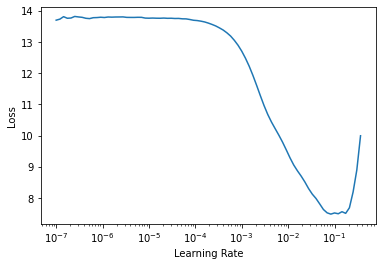

In [8]:
from fastai.callback import schedule

lr_min, lr_steep = learn.lr_find()

print('Learning rate with the minimum loss:', lr_min)
print('Learning rate with the steepest gradient:', lr_steep)

Now we want to run the training!

User-chosen variables:
- n_epochs: The number of epochs, i.e how many times the to run through all of the training data once
- lr: The learning rate. Either choose lr_min, lr_steep from above or set your own.


In [9]:
import time

print('--------------- START ---------------')
n_epochs=100
start = time.perf_counter() # Starts timer
learn.fit_one_cycle(n_epochs, lr_steep)
end = time.perf_counter() # Ends timer
delta_t = end - start
print('Training took', delta_t, 'seconds')

--------------- START ---------------
[0, 8.9879789352417, 5.660938262939453, '00:01']
[0, 8.9879789352417, 5.660938262939453, '00:01']
[1, 3.2329344749450684, 0.42903172969818115, '00:01']
[1, 3.2329344749450684, 0.42903172969818115, '00:01']
[2, 0.9290761351585388, 0.23570206761360168, '00:01']
[2, 0.9290761351585388, 0.23570206761360168, '00:01']
[3, 0.3926577866077423, 0.22855906188488007, '00:01']
[3, 0.3926577866077423, 0.22855906188488007, '00:01']
[4, 0.26579639315605164, 0.228567972779274, '00:01']
[4, 0.26579639315605164, 0.228567972779274, '00:01']
[5, 0.2357182800769806, 0.22846107184886932, '00:01']
[5, 0.2357182800769806, 0.22846107184886932, '00:01']
[6, 0.22857198119163513, 0.22933806478977203, '00:01']
[6, 0.22857198119163513, 0.22933806478977203, '00:01']
[7, 0.22539979219436646, 0.22050391137599945, '00:01']
[7, 0.22539979219436646, 0.22050391137599945, '00:01']
[8, 0.13497596979141235, 0.047903429716825485, '00:01']
[8, 0.13497596979141235, 0.047903429716825485, '00

[70, 7.13189147063531e-05, 3.6687590181827545e-05, '00:01']
[70, 7.13189147063531e-05, 3.6687590181827545e-05, '00:01']
[71, 5.46227784070652e-05, 1.6916867025429383e-05, '00:01']
[71, 5.46227784070652e-05, 1.6916867025429383e-05, '00:01']
[72, 5.612665700027719e-05, 5.2612045692512766e-05, '00:01']
[72, 5.612665700027719e-05, 5.2612045692512766e-05, '00:01']
[73, 3.98834454244934e-05, 1.552602043375373e-05, '00:01']
[73, 3.98834454244934e-05, 1.552602043375373e-05, '00:01']
[74, 4.111236921744421e-05, 2.5984994863392785e-05, '00:01']
[74, 4.111236921744421e-05, 2.5984994863392785e-05, '00:01']
[75, 2.982622572744731e-05, 2.6159605113207363e-05, '00:01']
[75, 2.982622572744731e-05, 2.6159605113207363e-05, '00:01']
[76, 2.6673038519220427e-05, 1.3967240192869212e-05, '00:01']
[76, 2.6673038519220427e-05, 1.3967240192869212e-05, '00:01']
[77, 2.3518805392086506e-05, 1.8017541151493788e-05, '00:01']
[77, 2.3518805392086506e-05, 1.8017541151493788e-05, '00:01']
[78, 2.3556540327263065e-05,

Then we plot the loss as a function of the epochs, for both train and test set. We check if we reach a plateau, i.e. whether the optimizer converged. We also check that the validation loss does not increase, i.e. that we don't overfit our data.

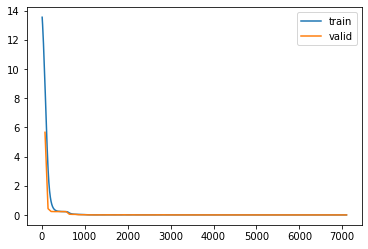

In [10]:
recorder.plot_loss()

Then we evaluate the MSE on this network - it should be of the order of 0.001 or less if all has gone well. If it has not trained as well, then it's going to be a bit higher.

In [11]:
learn.validate()

(#1) [5.699027497030329e-06]

Let's plot all of these, with ratios (thanks to code by Erik Wallin)

## Plotting the outputs of the network

Lazy-save of our output files (they'll also be on screen)

In [12]:
import os
save_dir = "plotOutput"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
save = False # Option to save figures

Make the histograms from the dataset.

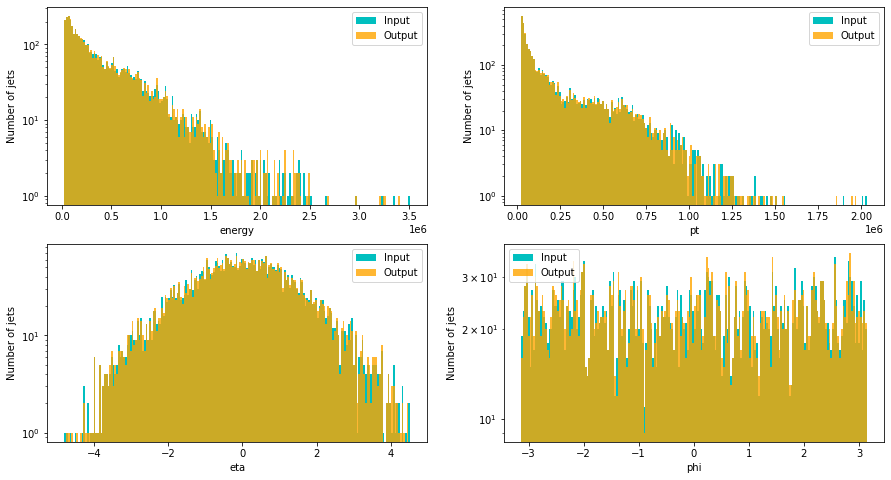

In [13]:
# Get the input and target data in the test set
test_x, test_y = full_ds[test_ds.indices]

# Let us evaluate our model on inference mode. At the moment,
# we don't have any batch normalization or dropout layers,
# but it's a good practice to call eval() nonetheless. Also,
# turn off gradients' computation to speed things up.
model.eval()
with torch.no_grad():
    pred = model(test_x)

data = test_y.detach().numpy()    # ground truth 4-momentum values
pred = pred.detach().numpy()      # predicted 4-momentum values

# Construct pandas data frames for the ground truth
# and the predicted data. The columns' labels are the
# same as the original data frame.
data_df = pd.DataFrame(data, columns=full_df.columns)
pred_df = pd.DataFrame(pred, columns=full_df.columns)

# Apply the inverse transformation, to go back to the
# physical units.
unnormalized_data_df = inverse_transform(data_df)
unnormalized_pred_df = inverse_transform(pred_df)    

# Plot the histograms for all the components of the 4-momentum,
# for both ground truth and predicted values, superimposed.
# Notice that we are using log-scale for the y-axis.
n_bins = 200
colors = ['orange', 'c']
plt.figure(figsize=(15, 8))
for i in np.arange(4):
    plt.subplot(2, 2, i+1)
    n_hist_data, bin_edges, _ = \
        plt.hist(data[:, i], color=colors[1], label='Input', alpha=1., bins=n_bins)
    n_hist_pred, _, _ = \
        plt.hist(pred[:, i], color=colors[0], label='Output', alpha=0.8, bins=bin_edges)
    plt.xlabel(full_df.columns[i])
    plt.ylabel('Number of jets')
    plt.yscale('log')
    if save:
        plt.savefig(os.path.join(save_dir, full_df.columns[i] + '.png'))
    plt.legend()

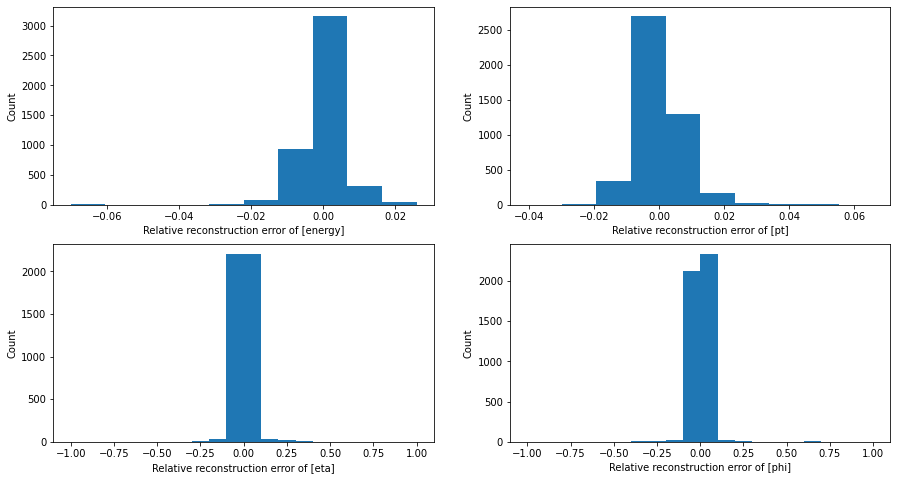

In [14]:
plt.figure(figsize=(15, 8))
for i in range(4):
    plt.subplot(2, 2, i+1)
    # Hack: Change bins for eta and phi
    bins = None
    if i > 1:
        binwidth = .1
        bins = np.arange(-1., 1. + binwidth, binwidth);
    plt.hist((pred[:,i] - data[:,i]) / data[:,i], bins=bins)
    plt.xlabel('Relative reconstruction error of [' + full_df.columns[i] + ']')
    plt.ylabel('Count')

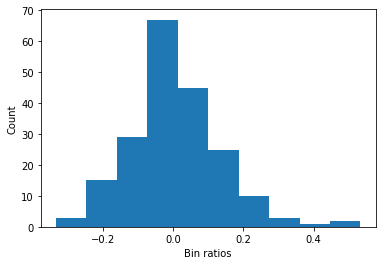

In [15]:
def getRatio(bin1, bin2):
    '''Given the values of the histogram bins bin1 and bin2,
    return a list of relative errors for every (bin1, bin2) pair.
    '''
    bins = []
    for b1, b2 in zip(bin1, bin2):
        if b1 == 0 and b2 == 0:
            bins.append(0.)
        elif b2 == 0:
            bins.append(None)
        else:
            bins.append((float(b2)-float(b1))/b1)
    return bins

ratios = getRatio(n_hist_data, n_hist_pred)
#print(rat)

plt.hist(ratios)
plt.xlabel('Bin ratios')
plt.ylabel('Count');